Anomaly detection in time series with Python | Data Science with Marco


https://www.youtube.com/watch?v=qy41dXGbAxY

In [2]:
# fonte dos dados
#https://github.com/numenta/NAB/blob/master/data/realAWSCloudwatch/ec2_cpu_utilization_24ae8d.csv

#https://github.com/numenta/NAB/blob/master/labels/combined_labels.json

outliers can affect the performance of forecasting models.

## Read the data 

The dataset can be downloaded from [GitHub](https://github.com/numenta/NAB/blob/master/data/realAWSCloudwatch/ec2_cpu_utilization_24ae8d.csv)

The labels can be obtained from [GitHub](https://github.com/numenta/NAB/blob/master/labels/combined_labels.json)

This is real-life data on CPU utilization of an EC2 instance in the AWS cloud. Data was recorded every 5 minutes, starting on February 14th at 14:30. The dataset contains 4032 data points. It is available through the Numenta Anomaly Benchmark (NAB) repository under the AGPL-3.0 license.

# Mean absolute deviation (MAD)

# Anomaly detection in time series 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [4]:
plt.rcParams["figure.figsize"] = (9,6)

In [7]:
df = pd.read_csv('ec2_cpu_utilization_24ae8d.csv') # Downloaded from the link above
df.head()

,timestamp,value
0,2014-02-14 14:30:00,0.132
1,2014-02-14 14:35:00,0.134
2,2014-02-14 14:40:00,0.134
3,2014-02-14 14:45:00,0.134
4,2014-02-14 14:50:00,0.134


In [8]:
# Labels taken from the link above. We are looking at the labels for ec2_cpu_utilization_24ae8d dataset

anomalies_timestamp = [
        "2014-02-26 22:05:00",
        "2014-02-27 17:15:00"
    ]

In [9]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

df.head()

,timestamp,value
0,2014-02-14 14:30:00,0.132
1,2014-02-14 14:35:00,0.134
2,2014-02-14 14:40:00,0.134
3,2014-02-14 14:45:00,0.134
4,2014-02-14 14:50:00,0.134


In [10]:
df['is_anomaly'] = 1

for each in anomalies_timestamp:
    df.loc[df['timestamp'] == each, 'is_anomaly'] = -1
    
df.head()

,timestamp,value,is_anomaly
0,2014-02-14 14:30:00,0.132,1
1,2014-02-14 14:35:00,0.134,1
2,2014-02-14 14:40:00,0.134,1
3,2014-02-14 14:45:00,0.134,1
4,2014-02-14 14:50:00,0.134,1


In [11]:
anomaly_df = df.loc[df['is_anomaly'] == -1]
inlier_df = df.loc[df['is_anomaly'] == 1]

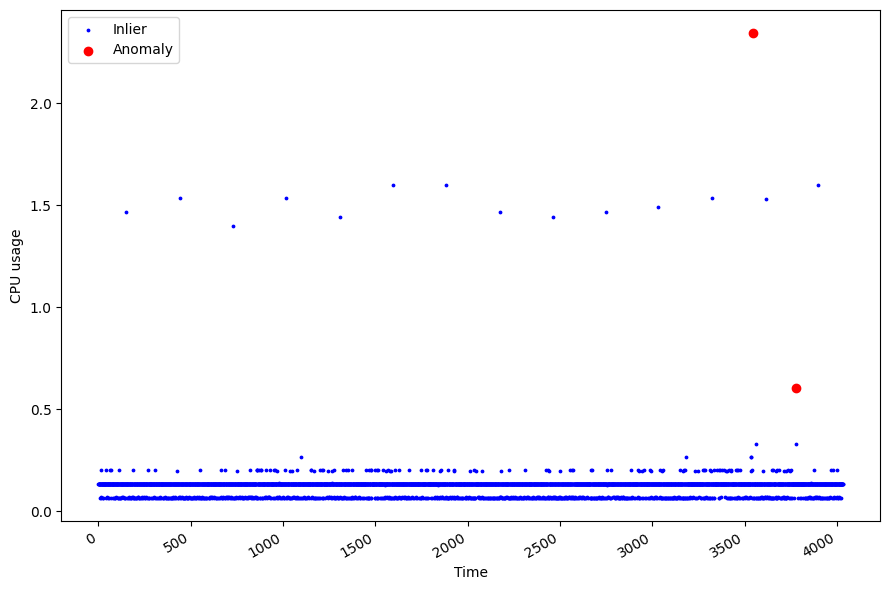

In [16]:
fig, ax = plt.subplots()

ax.scatter(inlier_df.index, inlier_df['value'], color='blue', s=3, label='Inlier')
ax.scatter(anomaly_df.index, anomaly_df['value'], color='red', label='Anomaly')
ax.set_xlabel('Time')
ax.set_ylabel('CPU usage')
ax.legend(loc=2)

plt.grid(False)
fig.autofmt_xdate()
plt.tight_layout()
plt.show();

## Baseline: median absolute deviation (MAD) 

when the data is normally distributed, we can reasonably conclude that points at each tail are outliers. 

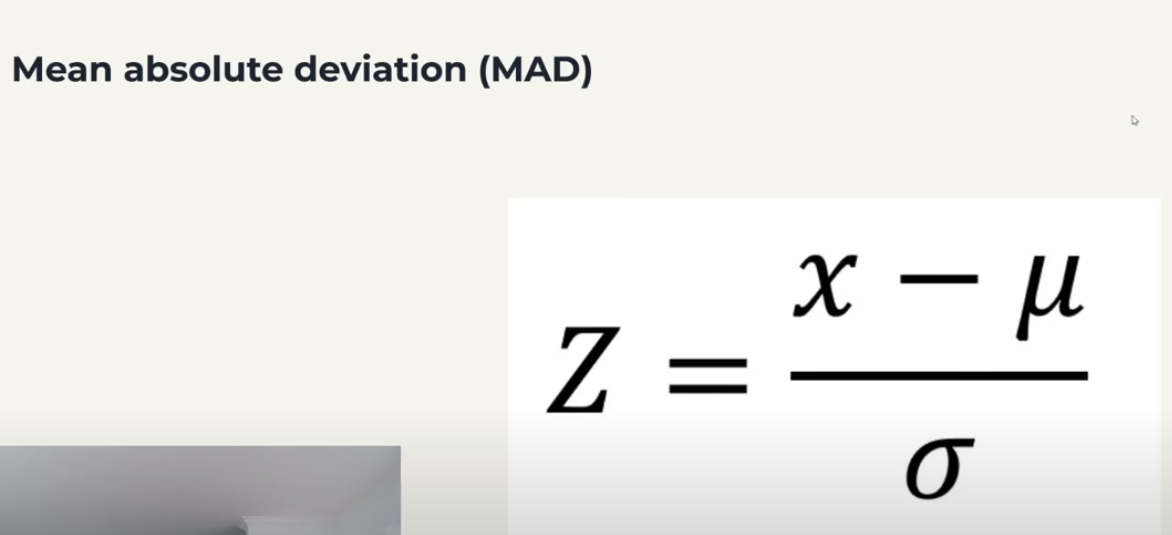

normal distribution

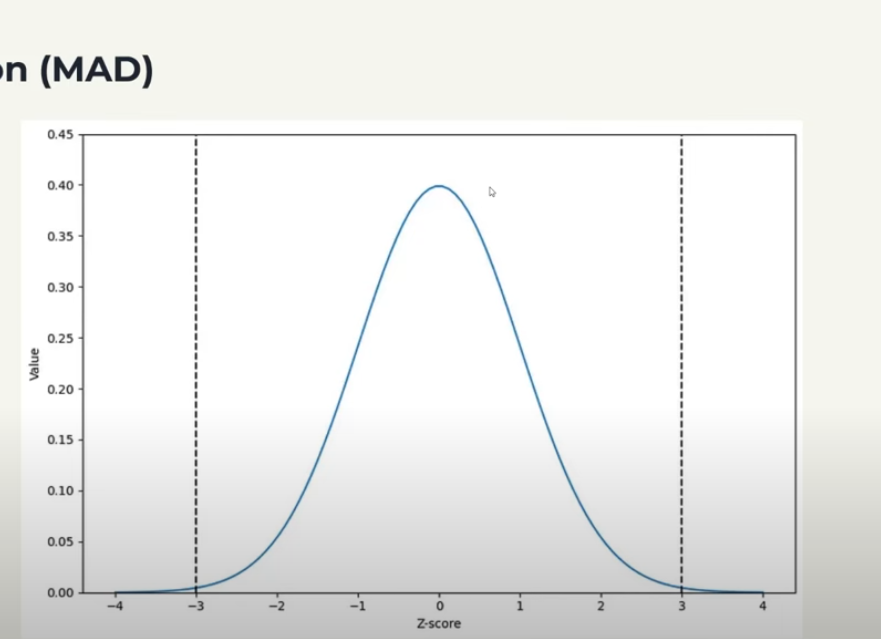

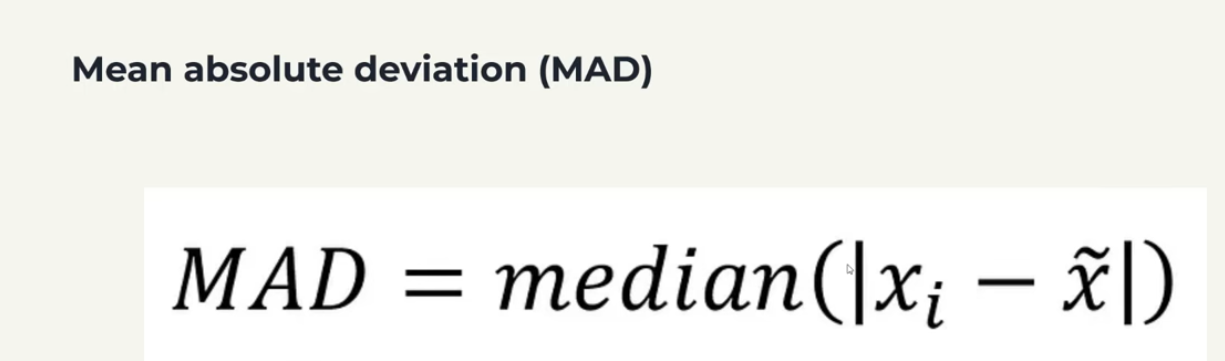

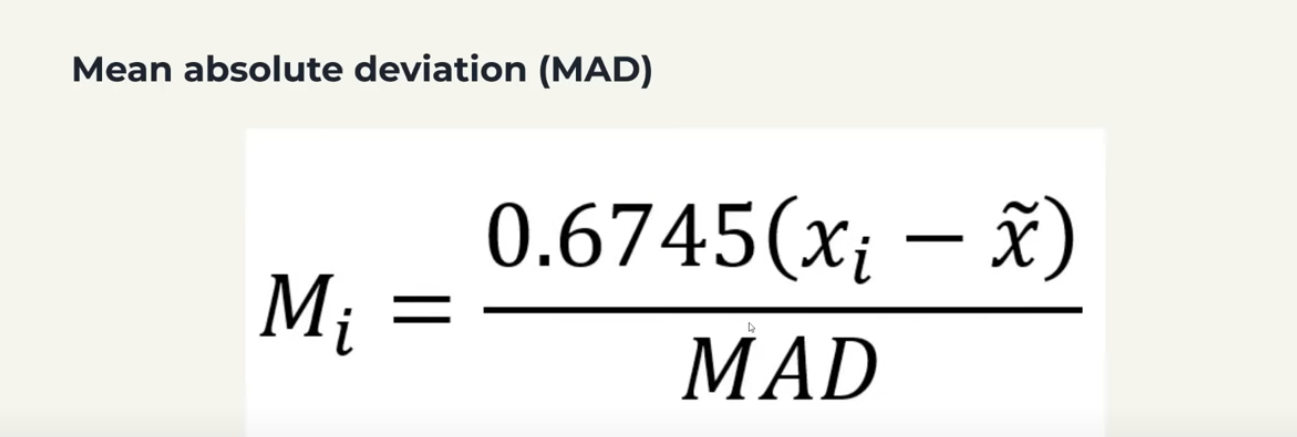

Careful

Robust Z-score works only if the data is close to a normal distribution

The MAD is not equal to 0 (happens when more than 50% of the data has the same value)

In [19]:
#!pip install seaborn

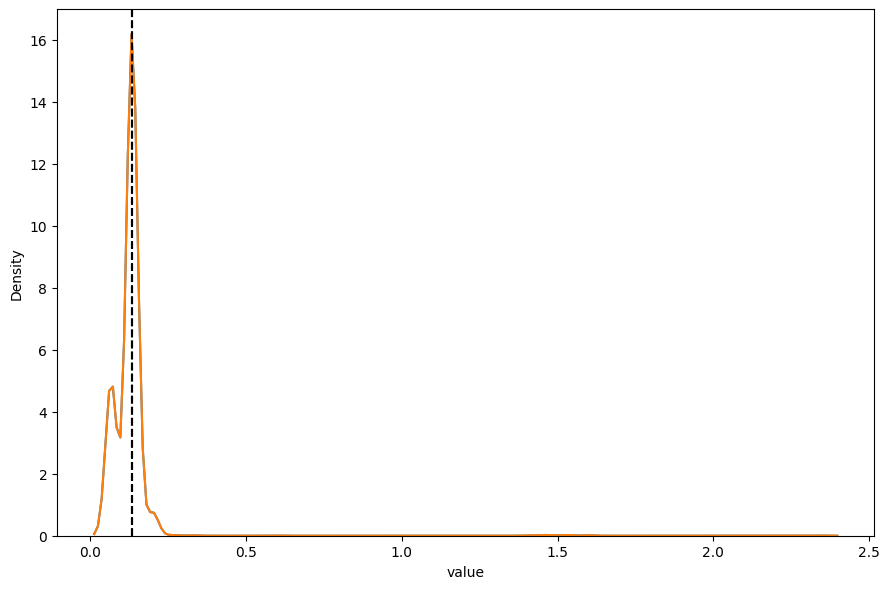

In [21]:
import seaborn as sns

sns.kdeplot(df['value']);
plt.grid(False)
plt.axvline(0.134, 0, 1, c='black', ls='--')
plt.tight_layout()
plt.show()

In [23]:
from scipy.stats import median_abs_deviation
#mad desvio padrão
mad = median_abs_deviation(df['value'])
median = np.median(df['value'])

print('median: ',median)
print('mad: ', mad)

def compute_robust_z_score(x):
    return .6745*(x-median)/mad

median:  0.134
mad:  0.0020000000000000018


In [24]:
df['z-score'] = df['value'].apply(compute_robust_z_score)

df.head()

,timestamp,value,is_anomaly,z-score
0,2014-02-14 14:30:00,0.132,1,-0.6745
1,2014-02-14 14:35:00,0.134,1,0.0000
2,2014-02-14 14:40:00,0.134,1,0.0000
3,2014-02-14 14:45:00,0.134,1,0.0000
4,2014-02-14 14:50:00,0.134,1,0.0000


## determine if it is an anomaly (use a threshold of 3.5)

In [25]:
df['baseline'] = 1

df.loc[df['z-score'] >= 3.5, 'baseline'] = -1
df.loc[df['z-score'] <=-3.5, 'baseline'] = -1

### Evaluation 

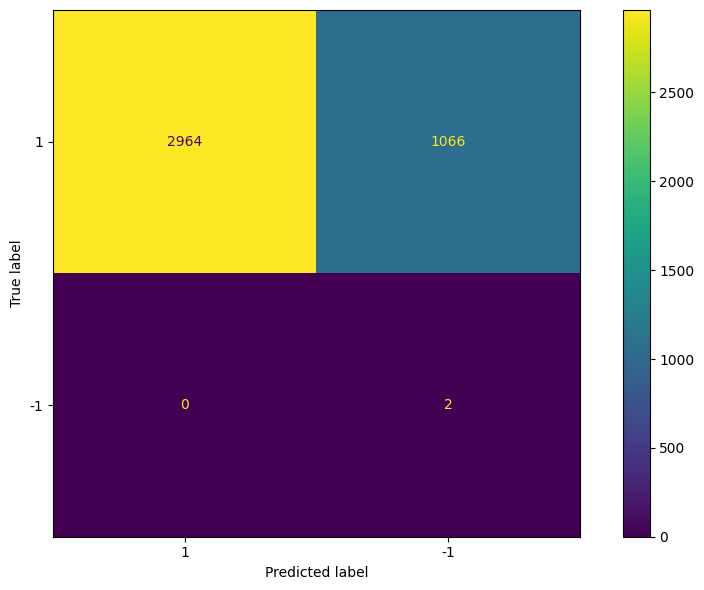

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(df['is_anomaly'], df['baseline'], labels=[1, -1])

disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1, -1])

disp_cm.plot();

plt.grid(False)
plt.tight_layout()
plt.show()

In [29]:
# two real outliers

## Isolation forest 




Tree-based algorithm to detect outliers

Partitions the data to isolate points

- many partitions - means the point is an inlier

- few partitions  - means the point is an outlier

inlier

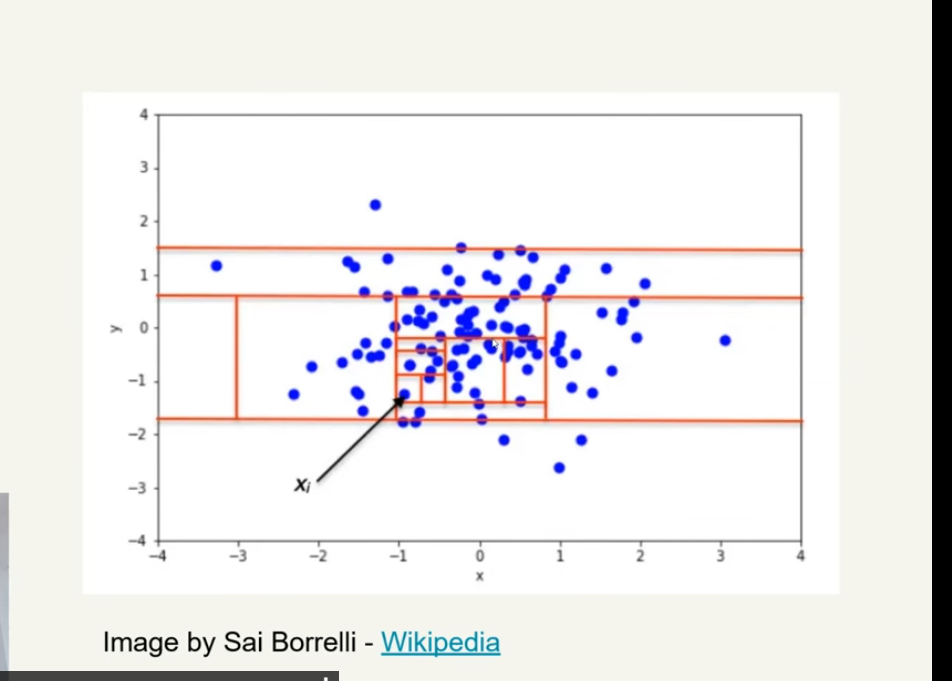

outlier:

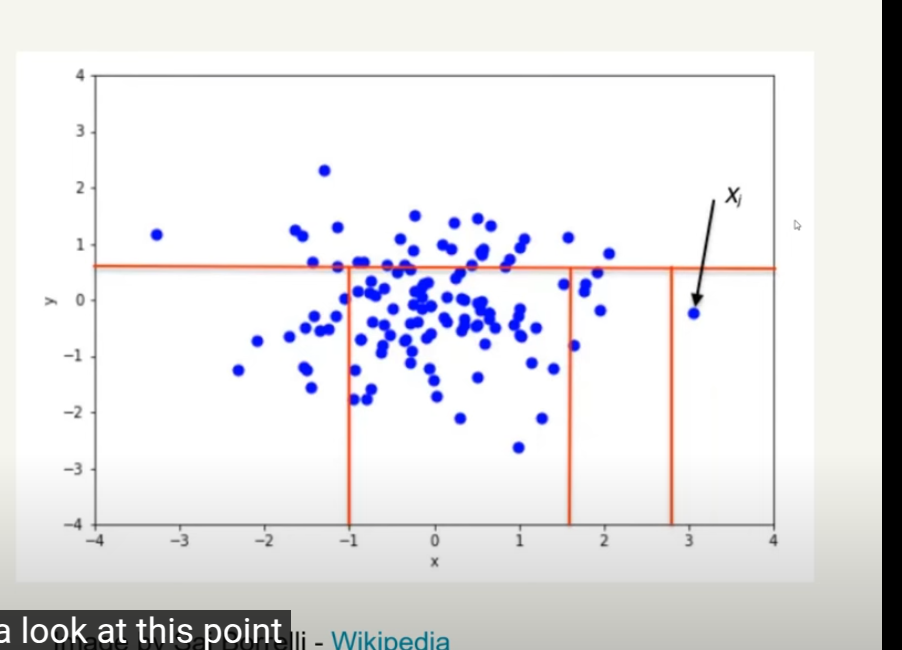

# local outlier factor (LOF) 

## Isolation forest 

In [30]:
from sklearn.ensemble import IsolationForest

In [31]:
train = df[:3550]
test = df[3550:]

In [32]:
contamination = 1/len(train)

iso_forest = IsolationForest(contamination=contamination, random_state=42)

X_train = train['value'].values.reshape(-1,1)

iso_forest.fit(X_train)

IsolationForest(contamination=0.00028169014084507044, random_state=42)

contaminatio = number of anomaly of anomalous points right in your training data. 

In [34]:
X_train

array([[0.132],
       [0.134],
       [0.134],
       ...,
       [2.344],
       [0.134],
       [0.066]])

.values – Converte a série pandas em um array NumPy.
    
.reshape(-1,1) – Reorganiza os dados para garantir que fiquem no formato de uma matriz de duas dimensões (n x 1), ou seja, uma coluna com n linhas.

In [37]:
len(train['value'].values.reshape(-1,1))

3550

In [38]:
preds_iso_forest = iso_forest.predict(test['value'].values.reshape(-1,1))

In [39]:
preds_iso_forest

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

### Evaluation 

In [40]:
# plot the confusion matrix

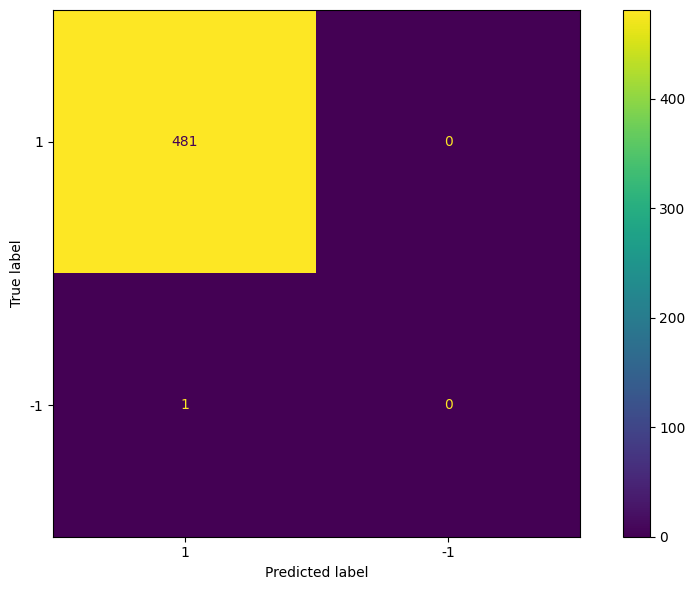

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test['is_anomaly'], preds_iso_forest, labels=[1, -1])

disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1, -1])

disp_cm.plot();

plt.grid(False)
plt.tight_layout()

plt.show()

In [42]:
# outlier -1 e -1, mas não é encontrado


## Local outlier factor (LOF)

Unsupervised method for anomaly detection

Intuition: Compare the local density of a point to that of its neighbors

If the density is smaller, then the point is isolated, so it's an outlier 


# Reachability distance



Local outlier factor (LOF)

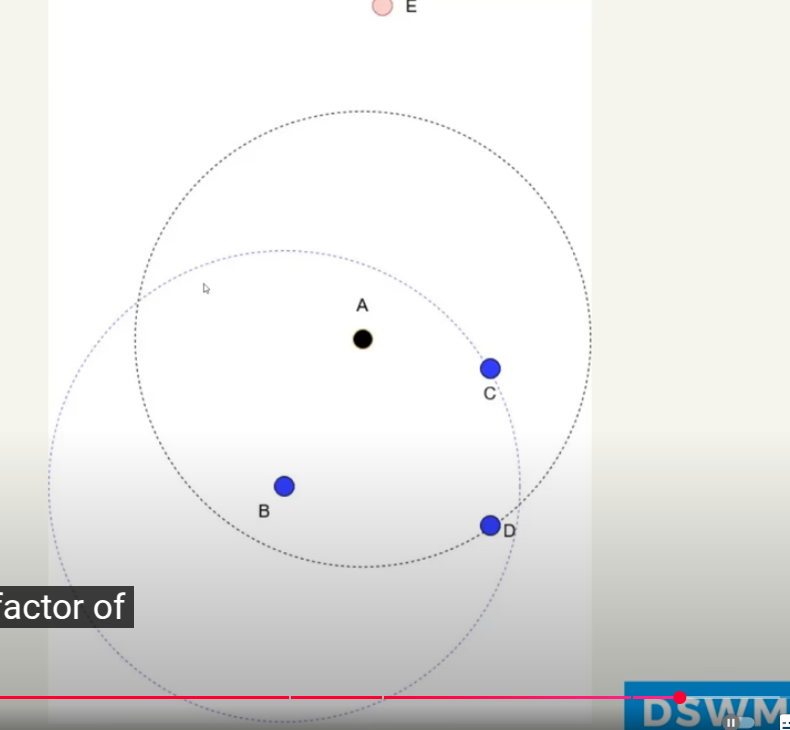



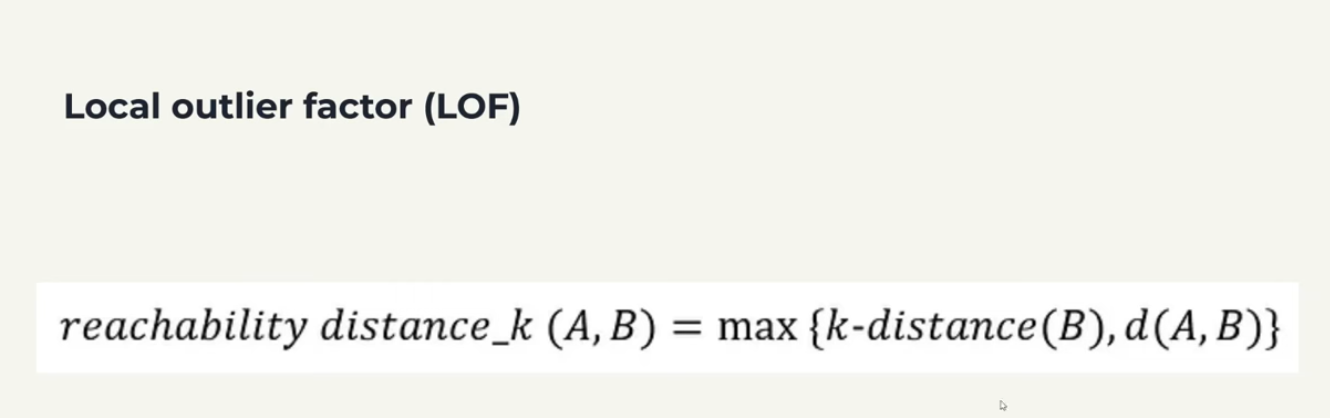

DISTANCE from B to C, A to B,

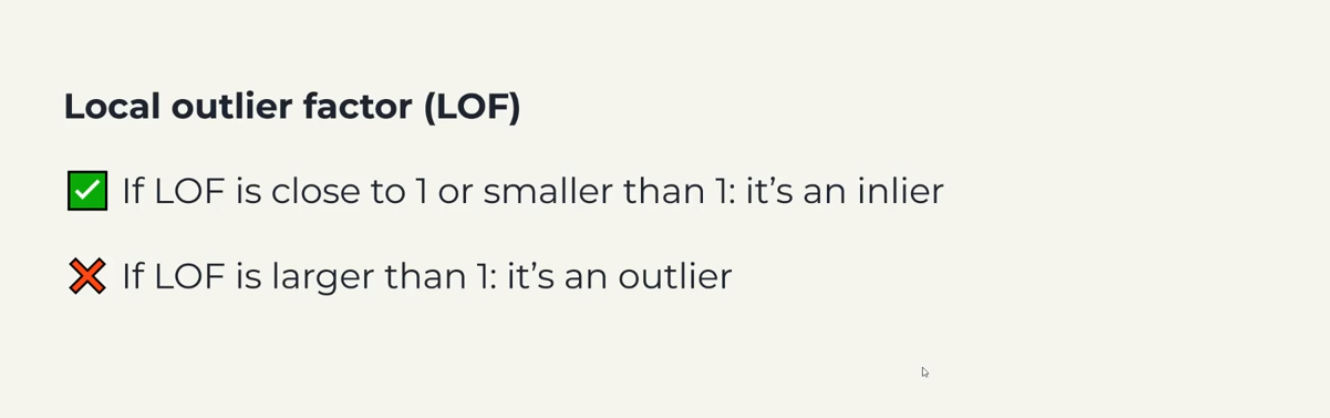

## Local outlier factor (LOF) 

In [43]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(contamination=contamination, novelty=True)

lof.fit(X_train)

LocalOutlierFactor(contamination=0.00028169014084507044, novelty=True)



predict method of local offline refactor => novelty =True

In [44]:
preds_lof = lof.predict(test['value'].values.reshape(-1,1))

In [45]:
preds_lof

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

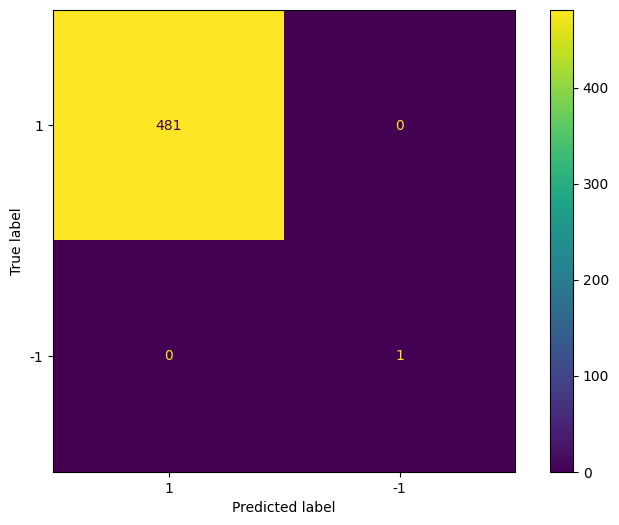

In [49]:
cm = confusion_matrix(test['is_anomaly'], preds_lof, labels=[1, -1])

disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1, -1])

disp_cm.plot();

plt.show()